In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import tensorflow as tf
from tensorflow import keras
import inspect
from tqdm import tqdm
import pandas as pd

#### Load

In [3]:
X_train_full = np.load('data_train.npy').T
t_train_full = np.load('labels_train.npy')

X_train_full.shape, t_train_full.shape

((6195, 270000), (6195,))

In [62]:
from sklearn.model_selection import train_test_split

# Training and Test sets
X_training, X_test, t_training, t_test = train_test_split(X_train_full, t_train_full, shuffle=True, stratify=t_train_full, test_size=0.15)
# Train/Learn and validation sets
X_train, X_val, t_train, t_val = train_test_split(X_training, t_training, shuffle=True, stratify=t_training, test_size=0.2)

X_train = X_train.reshape((X_train.shape[0],300,300,3))
X_val = X_val.reshape((X_val.shape[0],300,300,3))
X_test = X_test.reshape((X_test.shape[0],300,300,3))

class_names = ['Stop',
               'Yield',
               'Red Light',
               'Green Light',
               'Roundabout',
               'Right Turn Only',
               'Do Not Enter',
               'Crosswalk',
               'Handicap Parking',
               'No Parking']

class_num = len(class_names)

X_train.shape, t_train.shape, X_val.shape, t_val.shape, X_test.shape, t_test.shape, class_num

((4212, 300, 300, 3),
 (4212,),
 (1053, 300, 300, 3),
 (1053,),
 (930, 300, 300, 3),
 (930,),
 10)

In [5]:
batch_size = 32
num_iterations = int(X_train.shape[0] / batch_size)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, t_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, t_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, t_test))

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-07-27 17:38:51.720135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-27 17:38:51.720357: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
def normalize_img(image, label, img_size):
    # Resize image to the desired img_size and normalize it
    # One hot encode the label
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    label = tf.cast(label, tf.uint8)
    label = tf.one_hot(label, depth=class_num)
    return image, label
    
def preprocess_data(train, validation, test, batch_size, img_size):
    # Apply the normalize_img function on all train and validation data and create batches
    train_processed = train.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    train_processed = train_processed.batch(batch_size).repeat()
    
    validation_processed = validation.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    validation_processed = validation_processed.batch(batch_size)
    
    test_processed = test.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    test_processed = test_processed.batch(batch_size)
    
    return train_processed, validation_processed,test_processed
    
# Run preprocessing
train_processed, validation_processed, test_processed = preprocess_data(train_dataset, val_dataset, test_dataset, batch_size, img_size=[224,224])

In [38]:
base_model = keras.applications.DenseNet201(weights = 'imagenet', input_shape = (224,224,3), include_top = False, pooling='avg')
base_model.trainable = False

clf_model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(224,224,3)),
    base_model,
    tf.keras.layers.Dense(class_num, activation='softmax')
])

clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history = clf_model.fit(train_processed, epochs=20, validation_data=validation_processed, steps_per_epoch=num_iterations, callbacks=[keras.callbacks.EarlyStopping(patience=10), keras.callbacks.ModelCheckpoint('my_CNN_model.h5', save_best_only=True)])

Epoch 1/20


2022-07-27 18:24:02.061599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.8313 - accuracy: 0.7715

2022-07-27 18:24:25.762446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 37s 227ms/step - loss: 0.8313 - accuracy: 0.7715 - val_loss: 0.4593 - val_accuracy: 0.9022
Epoch 2/20
131/131 [==============================] - 29s 201ms/step - loss: 0.3284 - accuracy: 0.9313 - val_loss: 0.3406 - val_accuracy: 0.9250
Epoch 3/20
131/131 [==============================] - 27s 202ms/step - loss: 0.2355 - accuracy: 0.9526 - val_loss: 0.3043 - val_accuracy: 0.9316
Epoch 4/20
131/131 [==============================] - 27s 204ms/step - loss: 0.1912 - accuracy: 0.9648 - val_loss: 0.2919 - val_accuracy: 0.9392
Epoch 5/20
131/131 [==============================] - 27s 205ms/step - loss: 0.1639 - accuracy: 0.9715 - val_loss: 0.2779 - val_accuracy: 0.9449
Epoch 6/20
131/131 [==============================] - 26s 195ms/step - loss: 0.1446 - accuracy: 0.9744 - val_loss: 0.2750 - val_accuracy: 0.9478
Epoch 7/20
131/131 [==============================] - 27s 203ms/step - loss: 0.1295 - accuracy: 0.9768 - val_loss: 0.2732 - val_accuracy: 0.9

In [39]:
final_model = keras.models.load_model("./my_CNN_model.h5")

In [41]:
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense_3 (Dense)             (None, 10)                19210     
                                                                 
Total params: 18,341,194
Trainable params: 19,210
Non-trainable params: 18,321,984
_________________________________________________________________


### Deployment Test

[[[ 73  86  66]
  [ 95 108  88]
  [ 89 102  82]
  ...
  [ 47  54  47]
  [ 47  54  47]
  [ 46  53  46]]

 [[ 66  79  60]
  [ 87 100  81]
  [ 78  90  72]
  ...
  [ 44  51  43]
  [ 40  47  40]
  [ 38  45  38]]

 [[ 78  89  72]
  [ 91 102  86]
  [ 85  96  79]
  ...
  [ 44  51  43]
  [ 39  46  40]
  [ 39  46  39]]

 ...

 [[125 130 126]
  [129 134 130]
  [128 133 129]
  ...
  [137 138 133]
  [117 118 113]
  [105 106 101]]

 [[119 124 120]
  [121 126 122]
  [125 130 126]
  ...
  [146 147 142]
  [123 124 119]
  [107 108 103]]

 [[127 132 128]
  [120 125 121]
  [120 125 121]
  ...
  [117 118 113]
  [102 103  98]
  [ 99 100  95]]]
6.0
[[[ 71  75  48]
  [120 123 103]
  [100 104  87]
  ...
  [  4   6   3]
  [ 35  37  34]
  [ 34  36  33]]

 [[ 70  78  32]
  [102 108  70]
  [107 112  83]
  ...
  [ 33  35  32]
  [ 27  29  26]
  [ 32  34  31]]

 [[130 144  61]
  [119 131  55]
  [152 164  92]
  ...
  [ 29  31  29]
  [ 35  37  36]
  [ 24  26  25]]

 ...

 [[185 139 119]
  [235 195 171]
  [242 195 170]


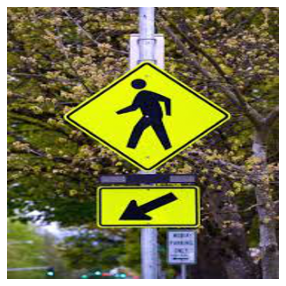

In [63]:
# Get image at index in test set
index = 929 # max of 930 - 1

# Begin test
num_elems = 0
element_save = 0
element_label = 0

# Extract single image from dataset
for element in test_dataset.as_numpy_iterator():
  print(element[0])
  print(element[1])
  num_elems = num_elems + 1
  if (num_elems == index):
    element_save = np.array(element[0])
    element_label = np.array(element[1])
    break
  
# Display Image
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(element_save/255.0)
plt.axis('off')

# Preprocess Image for Model
normalized_image, normalized_label = normalize_img(element_save, element_label, img_size=[224,224])

# Add extra axis to be able to put image in model
normalized_image = tf.expand_dims(normalized_image, axis = 0)

# Get label prediction
prediction = final_model.predict([normalized_image])

# Print Label
print('Actual: ' + class_names[int(element_label)])
print('Predicted: ',class_names[int(np.argmax(prediction))])